In [1]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.signal import medfilt
import pywt
from pywt import wavedec

In [2]:
DATASET_DIR = r'data\WFDBRecords'
print('DATASET DIR ::',DATASET_DIR)

DATASET DIR :: data\WFDBRecords


In [3]:
g_DATA = '.mat'
g_HEAD = '.hea'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6' ]
BASIC_SRATE = 500 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

Basic sampling rate(Hz): 500


In [4]:
rec_count = 0 
rec_count_expected = 0  # Initialize with 0, will be calculated below
rec_name_sep = ','
rec_file = open('RECORDS.txt', 'w')
# Traverse through all subfolders and files
for root, dirs, files in os.walk(DATASET_DIR):
    for f in files:
        if f.endswith(g_HEAD):
            rec_name = os.path.splitext(f)[0]  # Extract filename without extension
            rec_file.write(rec_name_sep + rec_name)
            rec_count += 1

    # Calculate the expected count by summing up the number of files with the desired extension
    rec_count_expected += len([f for f in files if f.endswith(g_HEAD)])

rec_file.seek(0)  # Move the file pointer to the beginning of the file
rec_file.write(str(rec_count_expected))  # Write the expected count to the beginning of the file
rec_file.close()

assert rec_count_expected == rec_count  # Assert the count equality
print(rec_count)

45152


In [5]:
load_txt = np.loadtxt('./RECORDS.txt', delimiter=',', dtype='str')
rec_count = int(load_txt[0])
rec_list = load_txt[1:]
print(rec_count,len(rec_list))

45152001 45151


In [6]:
class ecg_segment:
    # represent a 10 sec signal of ECG from 12 leads

    def __init__(self, seg_name):
        self.name = seg_name
        self.file_mat = None
        self.file_hea = None
        self.find_files()  # Search for the files across subfolders
        self.load_data()
        self.load_header()

    def find_files(self):
        # Walk through all subdirectories to find the matching .mat and .hea files
        for root, dirs, files in os.walk(DATASET_DIR):
            for file in files:
                if file.endswith('.mat') and file[:-4] == self.name:
                    self.file_mat = os.path.join(root, file)
                elif file.endswith('.hea') and file[:-4] == self.name:
                    self.file_hea = os.path.join(root, file)

        # Check if both files are found
        if self.file_mat is None or self.file_hea is None:
            raise FileNotFoundError(f"ECG segment {self.name} not found in the dataset directory.")

    def load_data(self):
        self.signals = loadmat(self.file_mat)['val'].astype(np.float64)
        self.signald = {}
        for i in range(0, len(g_leads)):
            self.signald[g_leads[i]] = self.signals[i, :]
        # an array of shape (12, 5000) each row is a lead in g_leads
        return

    def load_header(self):
        with open(self.file_hea, 'r') as f:
            hlines = f.readlines()  # each line ends with newline char
            # e.g., JS34506 12 500 5000 28-Mar-2021 04:58:01  
            tl = (hlines[0][0:-1]).split(" ")
            assert (tl[0] == self.name)
            assert (tl[1] == '12')
            assert (tl[2] == '500')
            assert (tl[3] == '5000')
            # Uncomment to handle timestamp extraction if necessary
            # self.timestamp = datetime.datetime.strptime("%d-%b-%Y_%H:%M:%S", tl[4] + '_' + tl[5])

            for i in range(1, 12):
                assert ((hlines[i][0:-1]).split(" ")[8] == g_leads[i - 1])

            self.age = int(hlines[13][0:-1].split(" ")[1])
            self.gender = hlines[14][0:-1].split(" ")[1]
            self.Dx = hlines[15][0:-1].split(" ")[1]
            self.Rx = hlines[16][0:-1].split(" ")[1]
            self.Hx = hlines[17][0:-1].split(" ")[1]
            self.Sx = hlines[18][0:-1].split(" ")[1]

        return

    def info(self):
        print(f"Name: {self.name}, Gender: {self.gender}, Age: {self.age}")
        return

In [7]:
recn = np.random.choice(rec_list, size=1)[0]  # total records = rec_count
ecg = ecg_segment(recn)
ecg.info()

Name: JS17174, Gender: Male, Age: 75


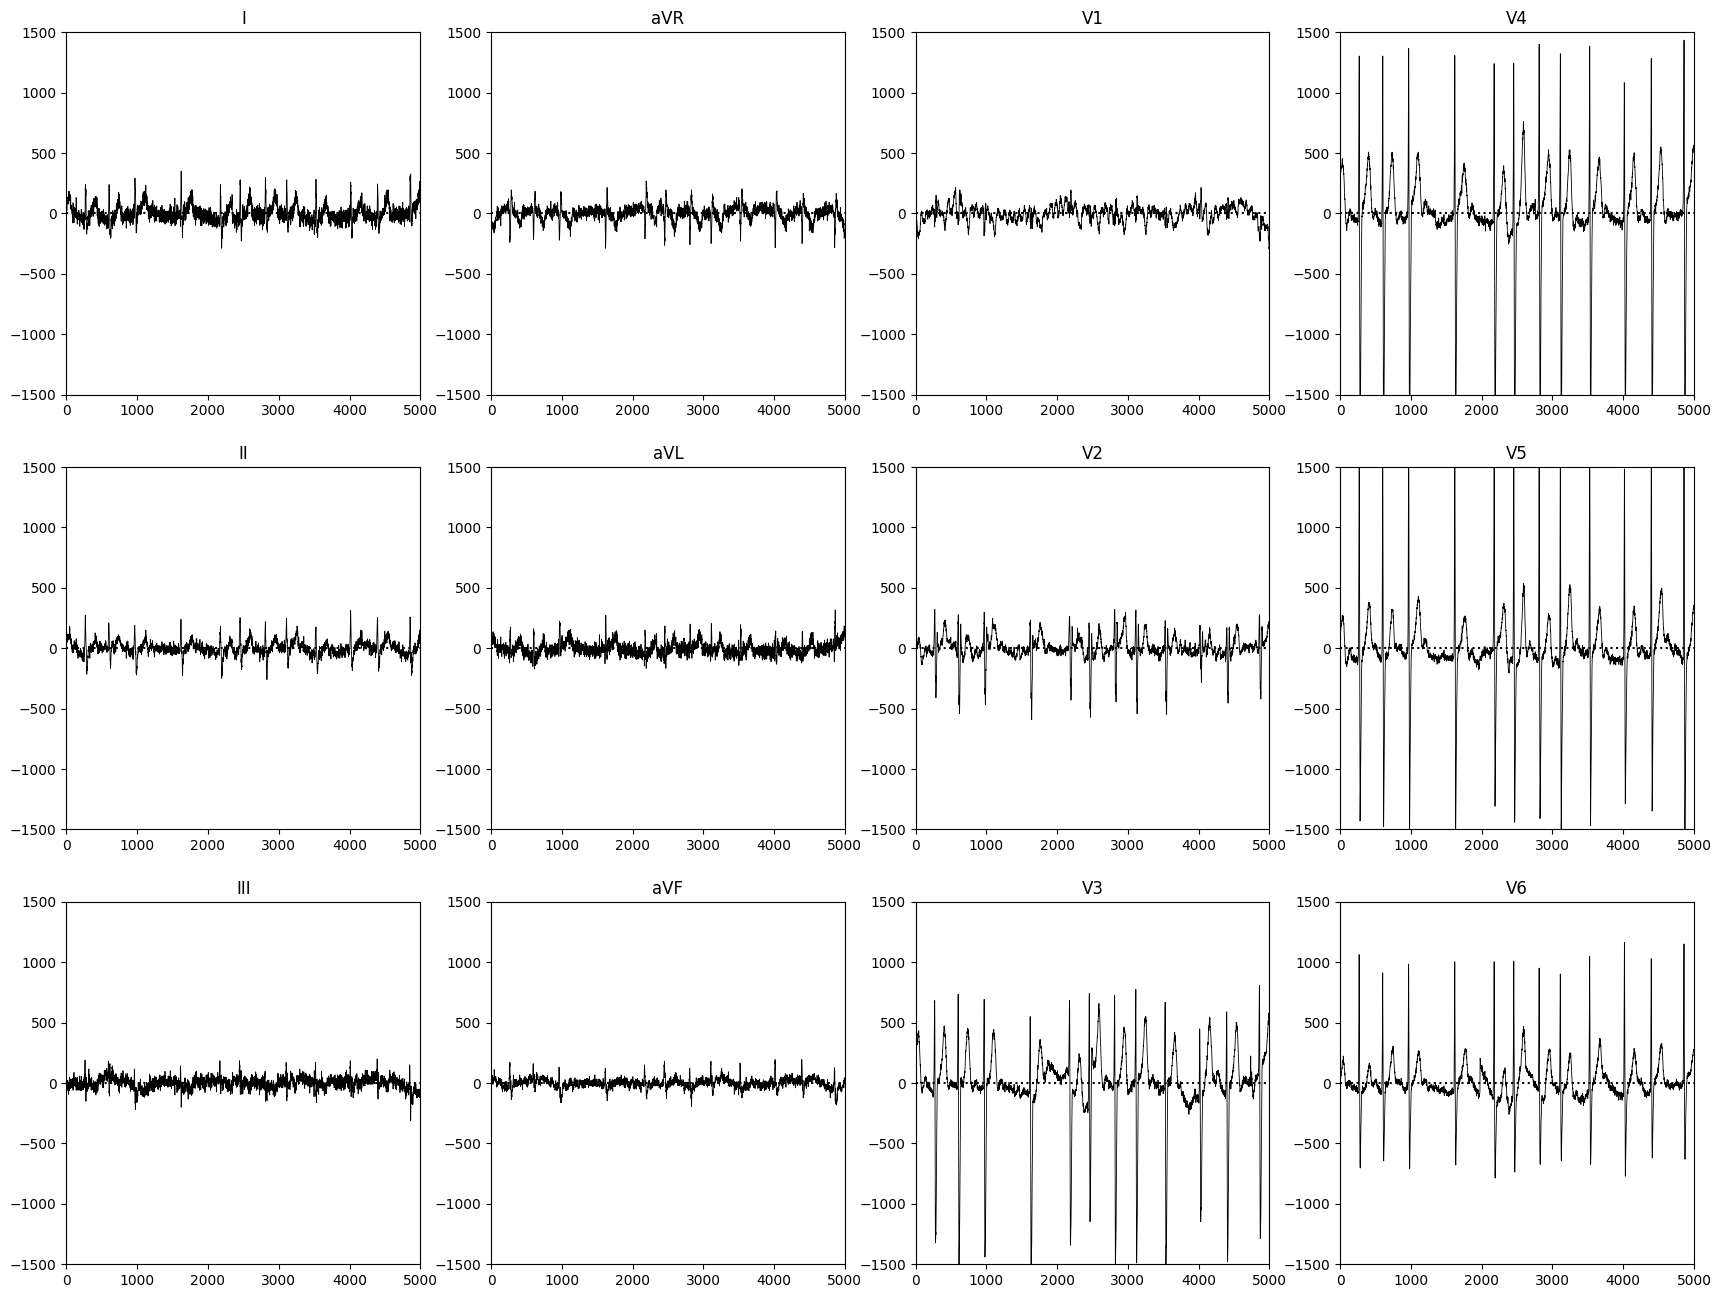

In [8]:
_lr,_lc = 3,4
_leads = [
    [['I'],['aVR'],['V1'],['V4']],
    [['II'],['aVL'],['V2'],['V5']],
    [['III'],['aVF'],['V3'],['V6']]
]


fig,ax = plt.subplots(_lr,_lc, figsize=(_lr*7,_lc*4))
#fig.set_dpi(150)
for i in range(0,3):
    for j in range(0,4):
        _key = _leads[i][j][0]
        ax[i,j].set_title(_key)
        ax[i,j].plot(ecg.signald[_key], color='black', linewidth=0.6)
        ax[i,j].set_ylim((-1500,1500))
        ax[i,j].set_xlim((0,5000))
        ax[i,j].hlines(0,0,5000,color='black',linestyle='dotted')


plt.show()


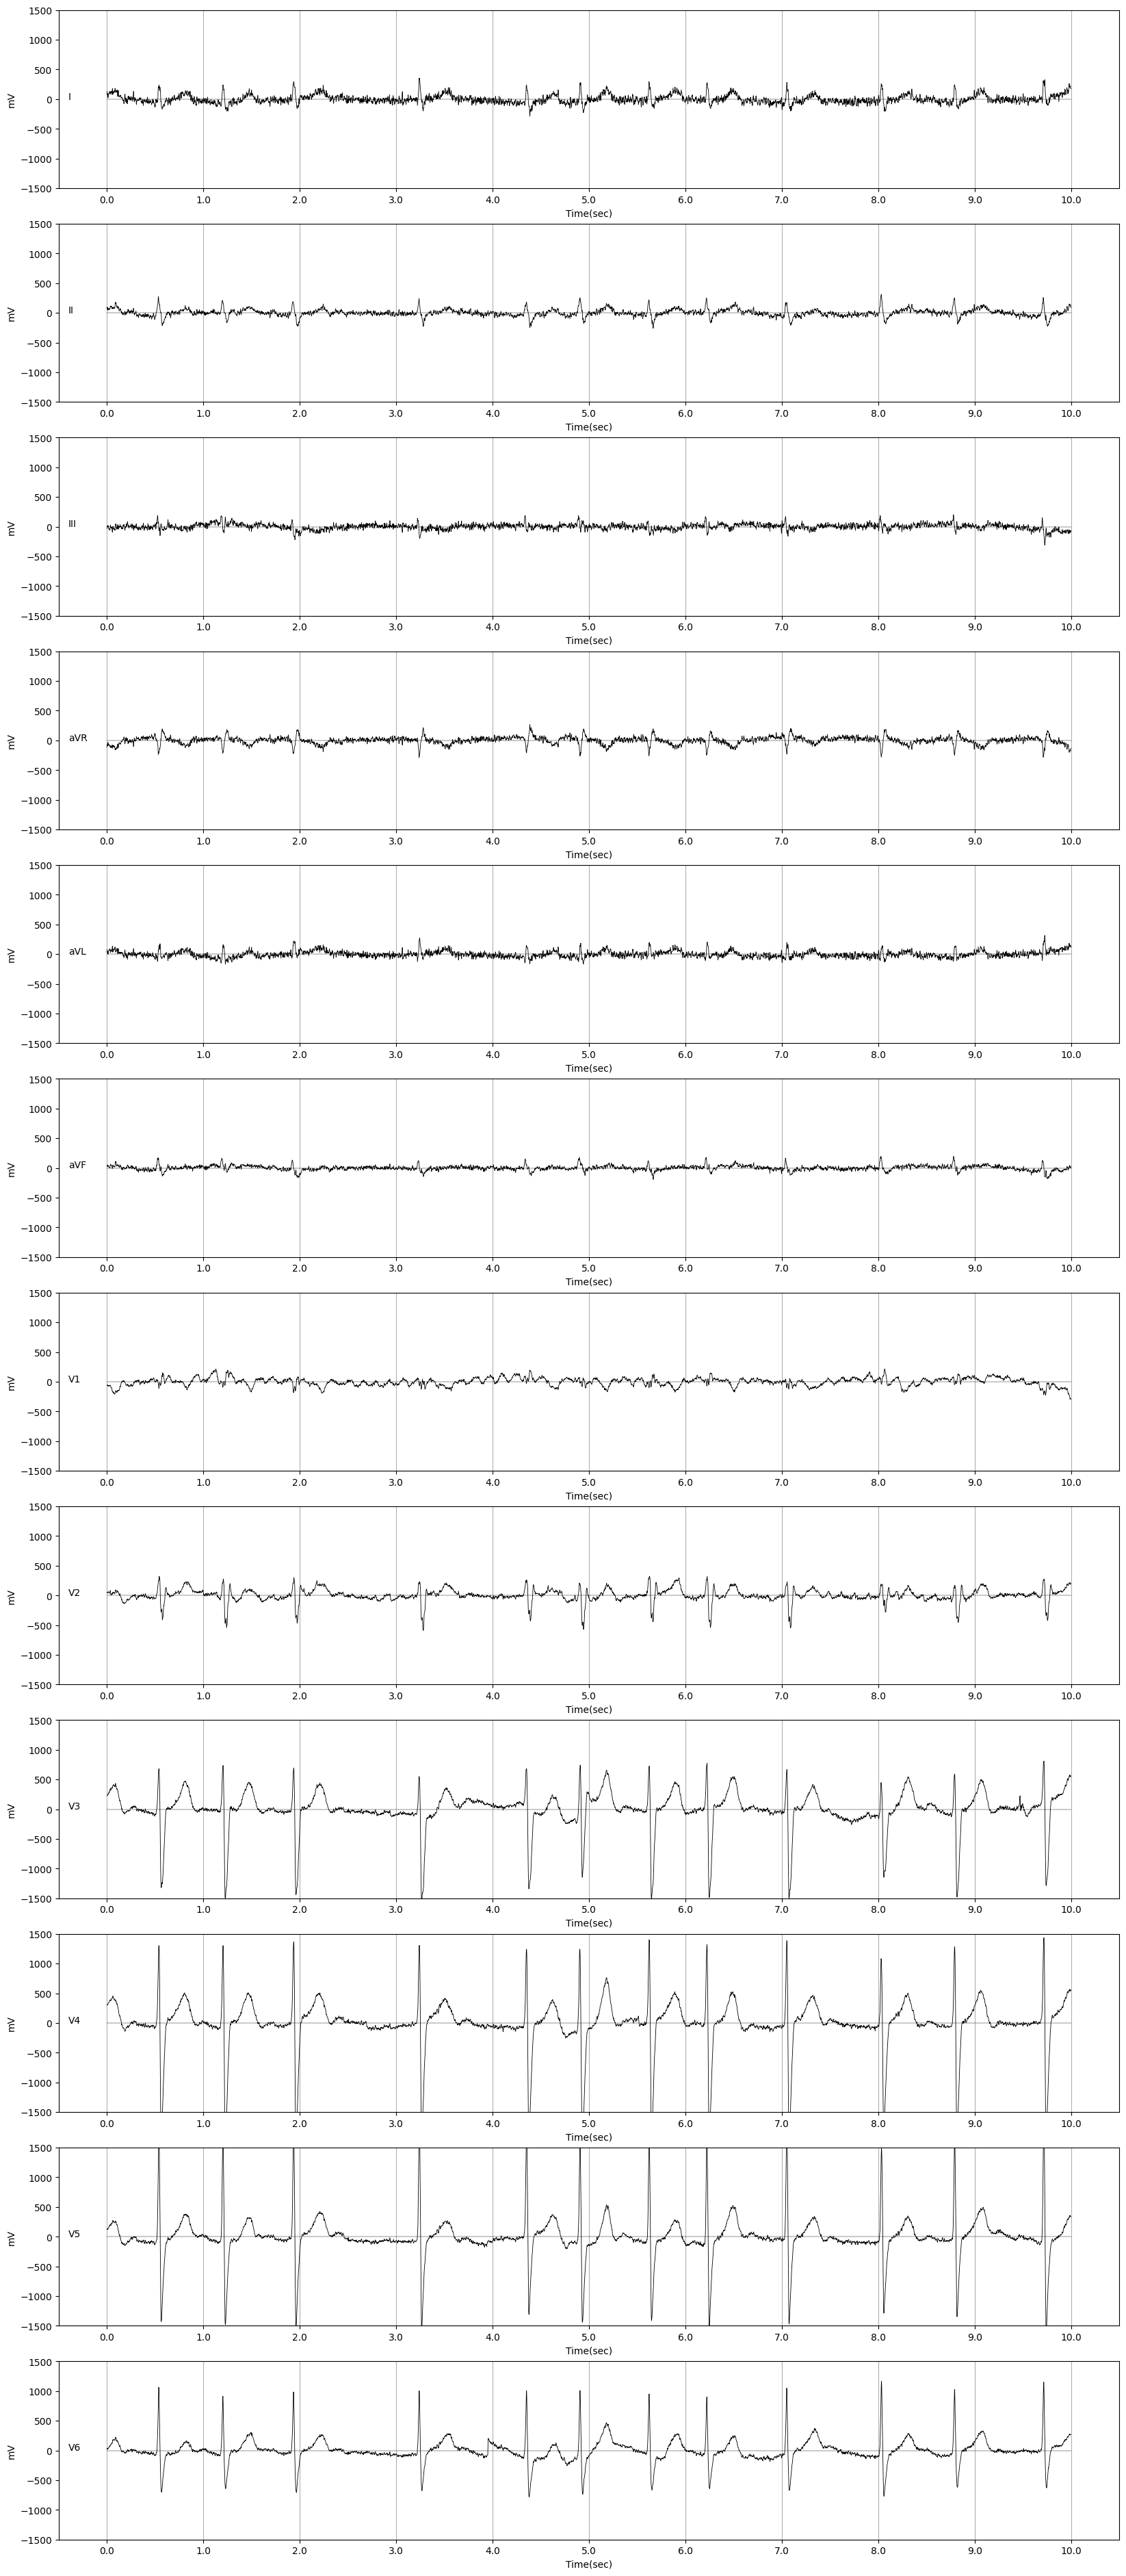

In [9]:
fig,ax = plt.subplots(12,1, figsize=(20,12*4))
#fig.set_dpi(150)
for i in range(0,12):
    _key = g_leads[i]
    #ax[i].set_title(_key)
    ax[i].plot(ecg.signald[_key], color='black', linewidth=0.6)
    ax[i].set_ylim((-1500,1500))
    ax[i].set_xticks(   np.arange(0,5001,500)  )   
    ax[i].set_xticklabels(   np.arange(0,5001,500)/BASIC_SRATE  )   
    ax[i].grid(axis='x')
    ax[i].annotate(_key,(-200,0))
    ax[i].set_xlabel('Time(sec)')
    ax[i].set_ylabel('mV')
    ax[i].hlines(0,0,5000,color='black', linewidth=0.3)


plt.show()

Raw Signal View

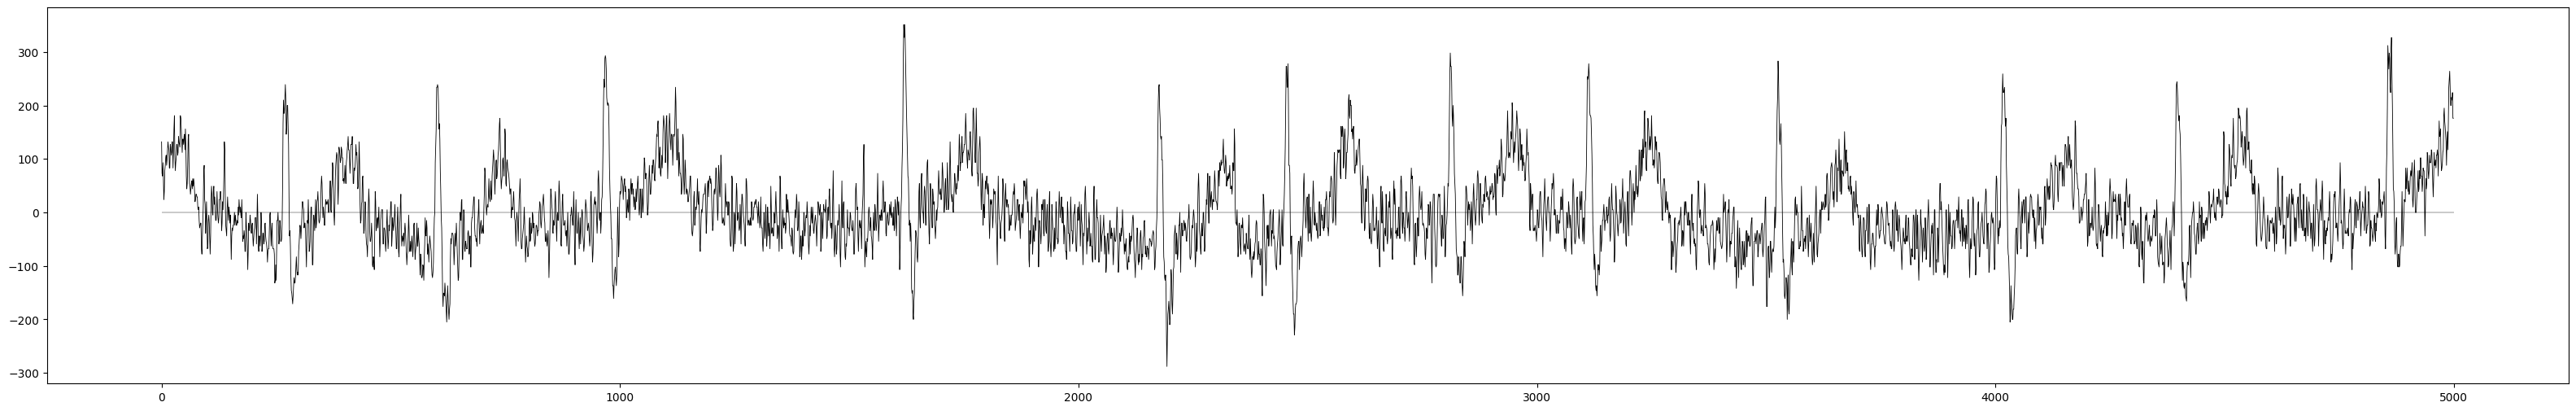

In [10]:
signal = ecg.signald['I']  #<<---- choosen Lead

plt.figure(figsize=(40,6))
plt.plot(signal, color='black', linewidth=0.6)
plt.hlines(0,0,5000,color='black', linewidth=0.3)

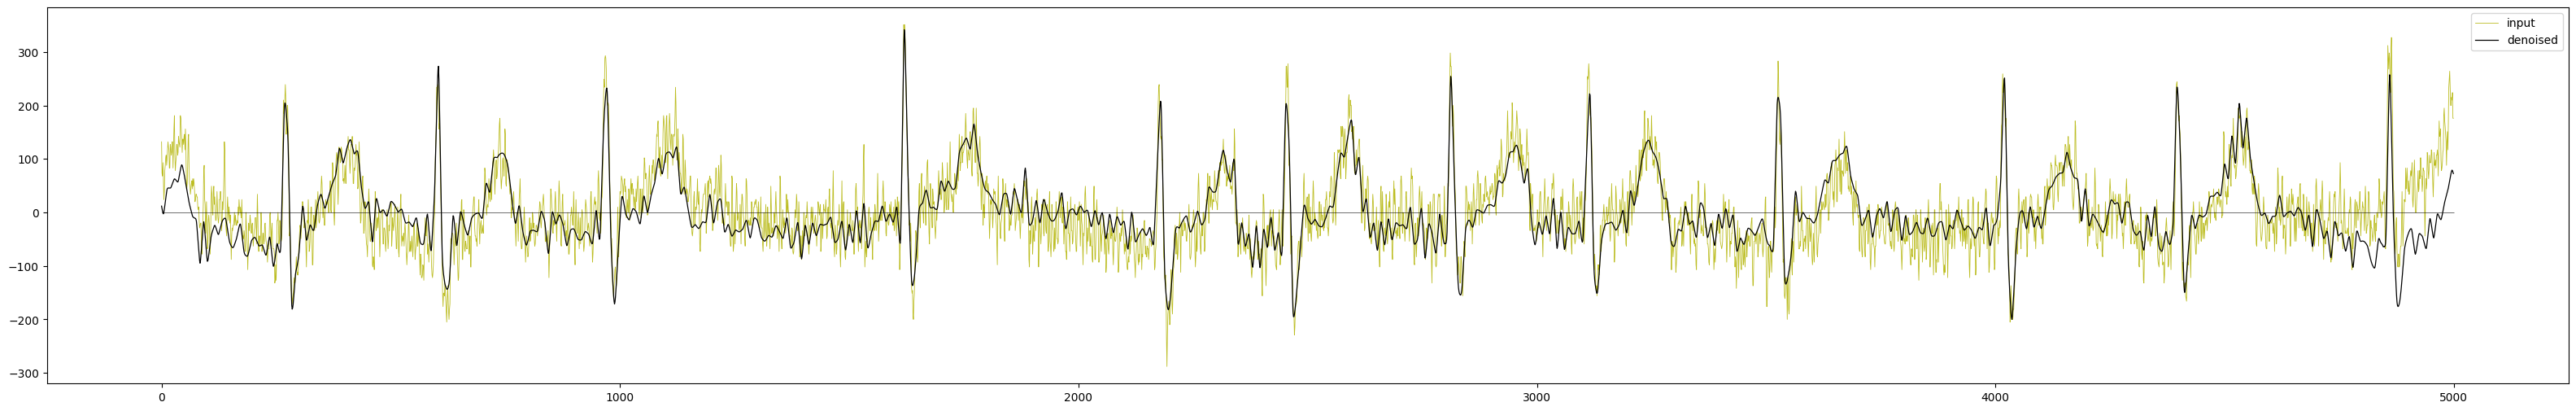

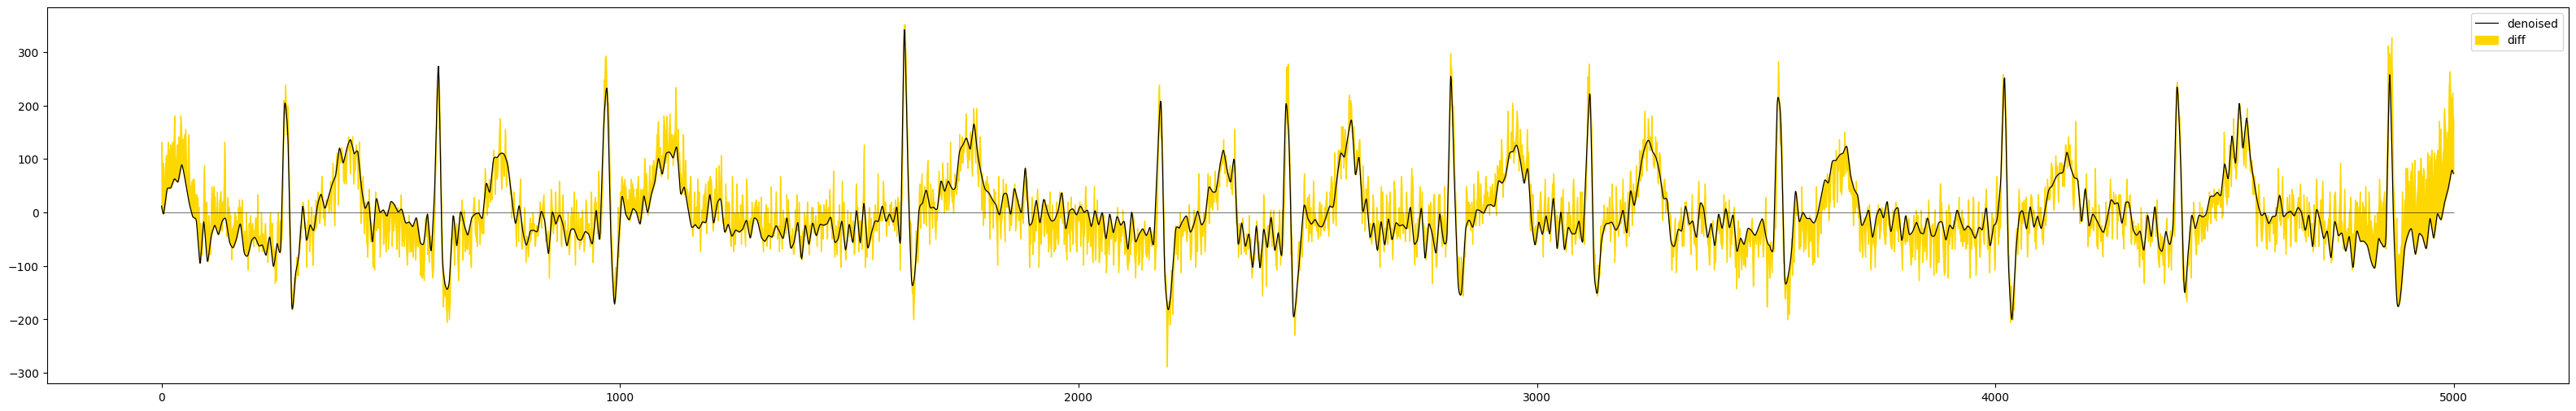

In [11]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  


signal_den = denoise_signal(signal,'bior4.4', 9 , 1 , 7) #<--- trade off - the less the cutoff - the more R-peak morphology is lost
plt.figure(figsize=(40,6))

plt.plot(signal, color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.fill_between(np.arange(0,5000,1),signal,signal_den,color='gold',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()


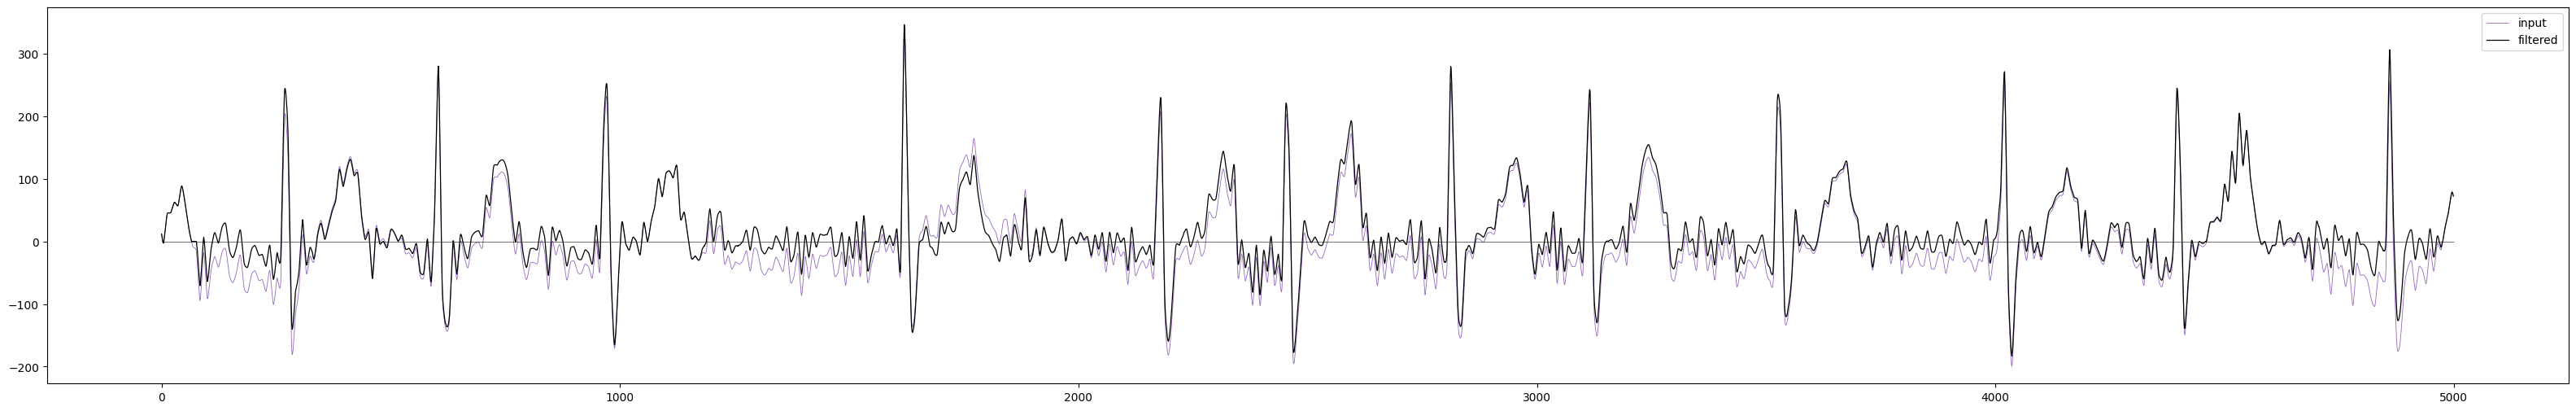

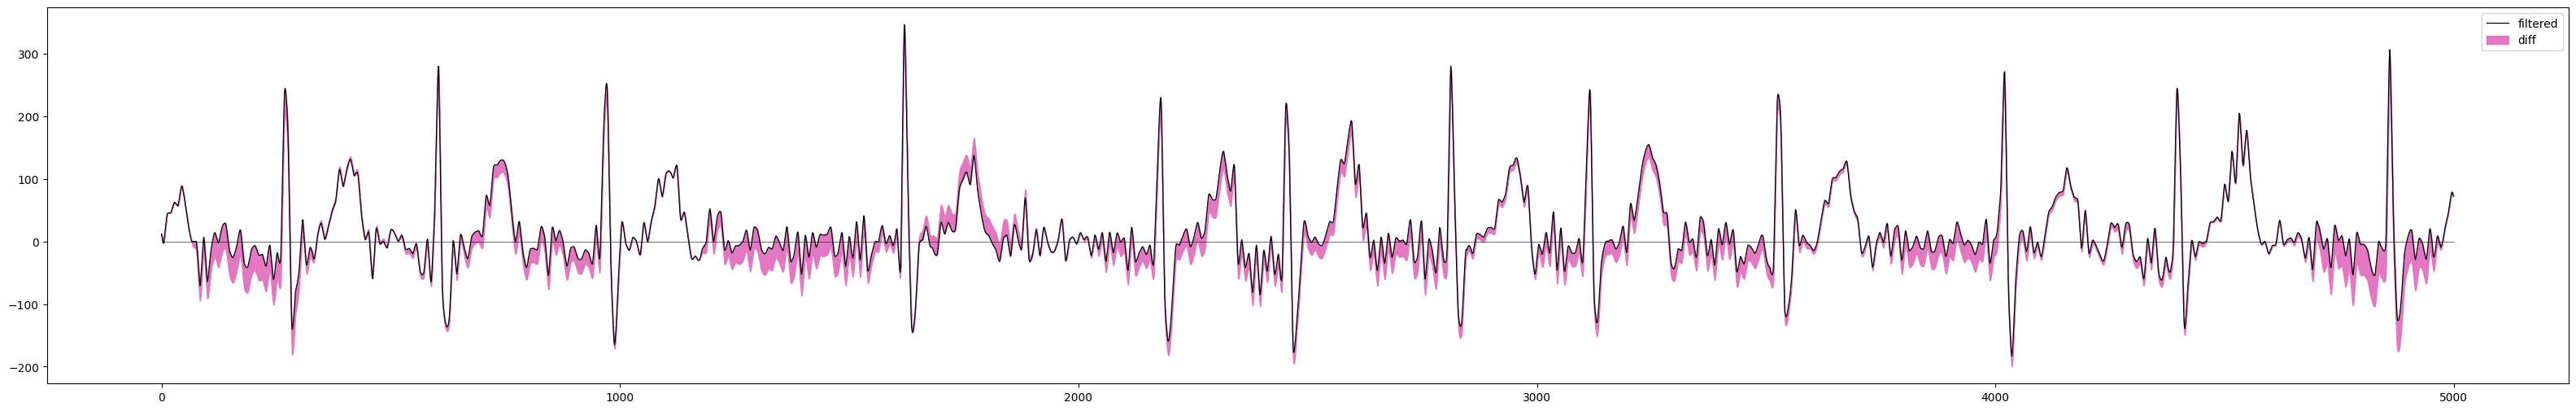

In [12]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res
# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(BASIC_SRATE,ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0



signal_flt = filter_signal(signal_den)
plt.figure(figsize=(40,6))

plt.plot(signal_den, color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.fill_between(np.arange(0,5000,1),signal_den,signal_flt,color='tab:pink',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

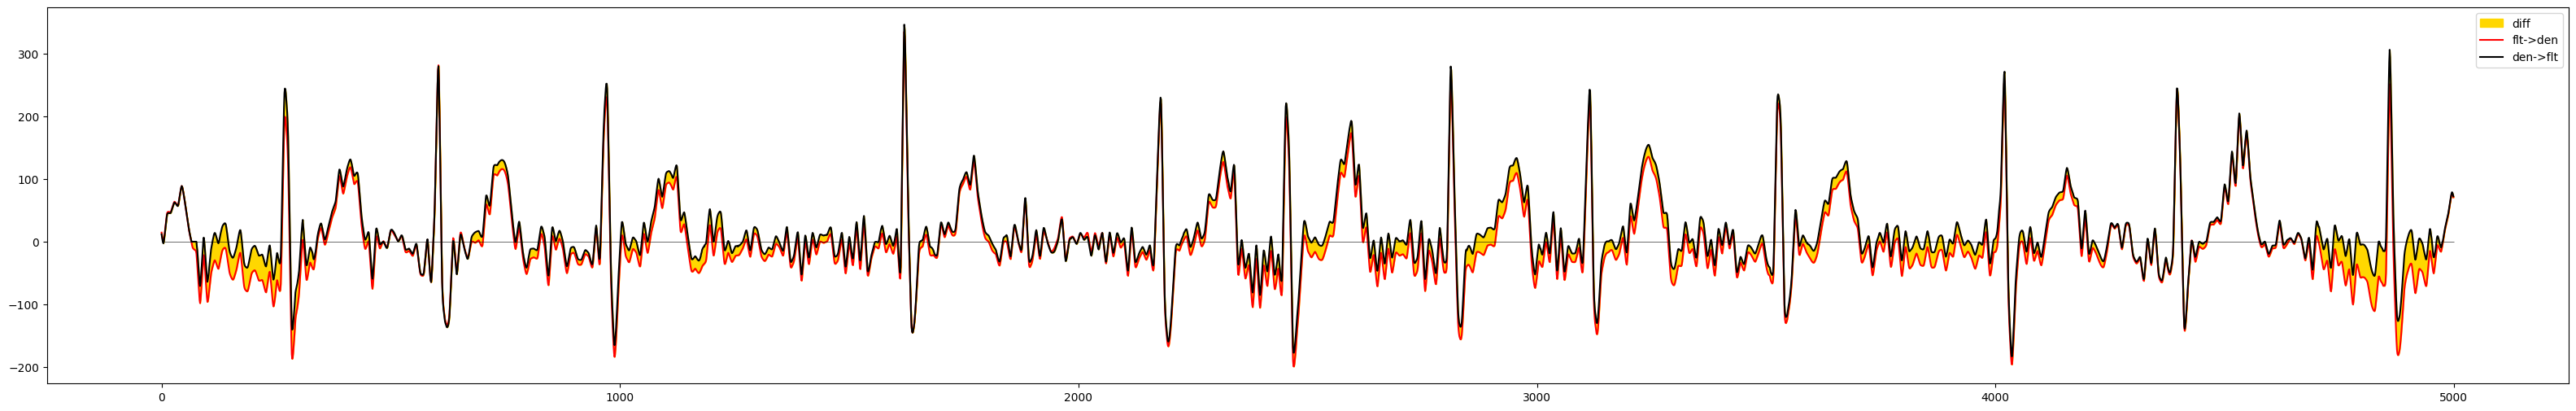

In [13]:
s1 = denoise_signal(filter_signal(signal),'bior4.4', 9 , 1 , 7) # first filtered then denoised
s2 = filter_signal(denoise_signal(signal,'bior4.4', 9 , 1 , 7)) #first denoised then filtered

plt.figure(figsize=(40,6))

#plt.plot(signal, color='black', linewidth=0.4,label = 'input')
plt.fill_between(np.arange(0,5000,1),s1,s2,color='gold',label = 'diff')
plt.plot(s1, color='red',label = 'flt->den')
plt.plot(s2, color='black',label = 'den->flt')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()


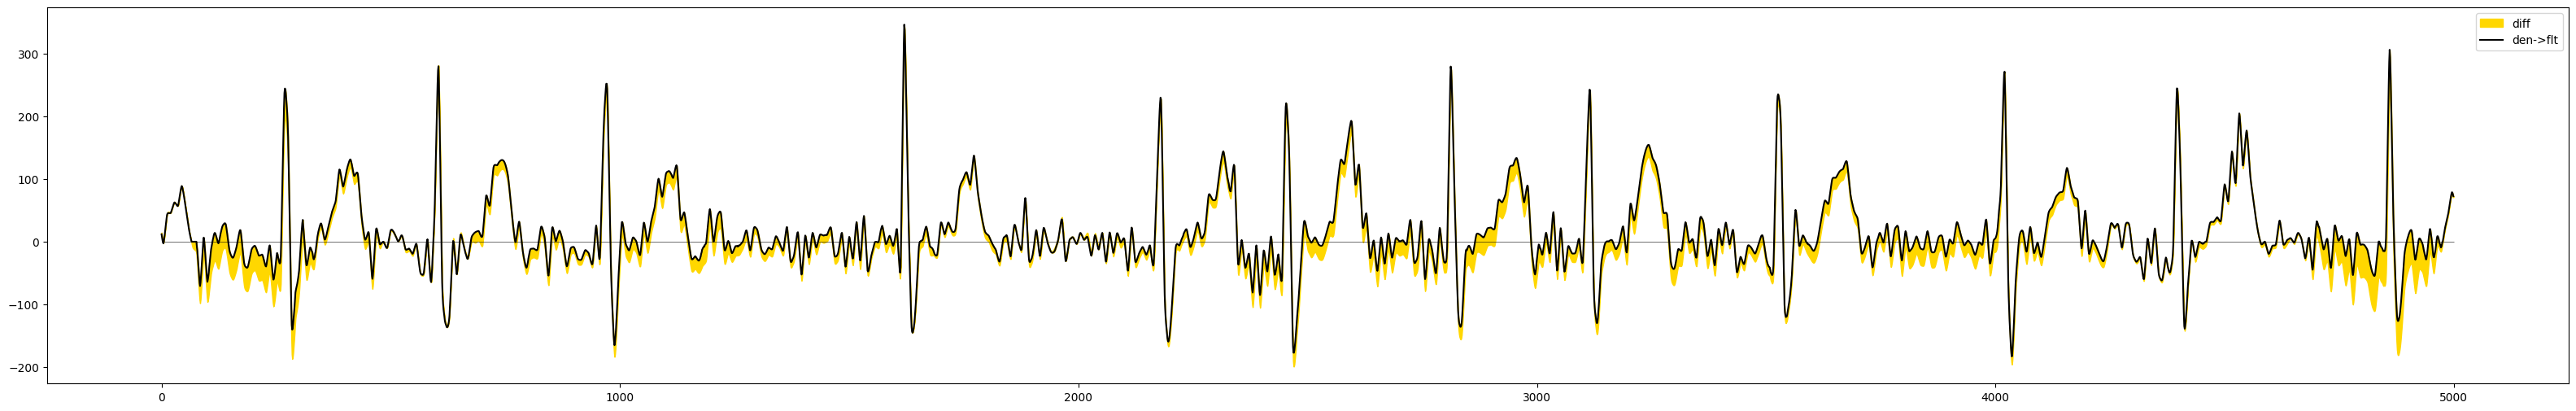

In [14]:

s2 = filter_signal(denoise_signal(signal,'bior4.4', 9 , 1 , 7)) #first denoised then filtered

plt.figure(figsize=(40,6))

#plt.plot(signal, color='black', linewidth=0.4,label = 'input')
plt.fill_between(np.arange(0,5000,1),s1,s2,color='gold',label = 'diff')

plt.plot(s2, color='black',label = 'den->flt')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()
